In [1]:
%cd drive/My\ Drive/Colab\ Notebooks/arXiv/arXiv-NLP-Streamlit-App

/content/drive/.shortcut-targets-by-id/1B34FhCd94U_En6aSlT1jk3rYaPN2ehvs/arXiv/arXiv-NLP-Streamlit-App


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from utils import *
from data.categories import cat_map
%matplotlib inline

In [3]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
df = data_to_df(cat_map, min_year=2010)

In [5]:
df, class_array = preprocess_data(df, save_pqt=True)

In [6]:
df.head()

,text,categories,category_encoding
0,Coincidence of the oscillations in the dipole ...,[cond-mat.mes-hall],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,Biased random walks on combs. We develop rigor...,[cond-mat.other],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,Superconducting states of the quasi-2D Holstei...,[cond-mat.supr-con],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Possibility of Gapless Spin Liquid State by On...,[cond-mat.str-el],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,A High Robustness and Low Cost Model for Casca...,[physics.soc-ph],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
class_array

array(['astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA',
       'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR', 'cond-mat.dis-nn',
       'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other',
       'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech',
       'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.CL', 'cs.CR',
       'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.LO', 'cs.NI', 'cs.RO',
       'cs.SE', 'eess.SP', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph',
       'hep-th', 'math.AG', 'math.AP', 'math.CA', 'math.CO', 'math.DG',
       'math.DS', 'math.FA', 'math.GT', 'math.NA', 'math.NT', 'math.OC',
       'math.PR', 'nlin.CD', 'nlin.PS', 'nucl-ex', 'nucl-th',
       'physics.acc-ph', 'physics.app-ph', 'physics.atom-ph',
       'physics.chem-ph', 'physics.class-ph', 'physics.flu-dyn',
       'physics.gen-ph', 'physics.ins-det', 'physics.optics',
       'physics.plasm-ph', 'physics.soc-ph', 'q-bio.PE', 'quant-ph',
       'stat.ME'], dtype=object)

In [11]:
from simpletransformers.classification import MultiLabelClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False, 
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
    "use_cuda":True
}

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel('distilbert', 
                                      'distilbert-base-uncased',
                                      num_labels=len(class_array), 
                                      args=model_args)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForMultiLabelSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultiLabelSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

In [12]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(df, test_size=0.1, stratify=df["categories"], random_state=42)

# Train the model
model.train_model(train_df[["text", "category_encoding"]], verbose=0)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["text", "category_encoding"]])
print(result)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:377: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:896: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."



{'LRAP': 0.8860066880176761, 'eval_loss': 0.017357773973109884}


In [13]:
from sklearn.metrics import classification_report

predicted_categories_argmax = list(map(lambda x: np.argmax(x), model_outputs))

predicted_categories_encoded = np.eye(len(class_array))[predicted_categories_argmax]
predicted_categories = class_array[np.nonzero(predicted_categories_encoded)[1]].tolist()

eval_labels = eval_df["categories"].tolist()

print(classification_report(predicted_categories, eval_labels,
                            target_names=class_array))

                    precision    recall  f1-score   support

          astro-ph       0.09      0.20      0.12        41
       astro-ph.CO       0.78      0.79      0.78       330
       astro-ph.EP       0.89      0.90      0.90       184
       astro-ph.GA       0.85      0.77      0.81       340
       astro-ph.HE       0.83      0.79      0.81       266
       astro-ph.IM       0.69      0.78      0.73        90
       astro-ph.SR       0.88      0.88      0.88       353
   cond-mat.dis-nn       0.60      0.57      0.59        93
 cond-mat.mes-hall       0.82      0.76      0.79      1408
 cond-mat.mtrl-sci       0.69      0.76      0.73       822
    cond-mat.other       0.11      0.33      0.17        18
cond-mat.quant-gas       0.84      0.79      0.81       374
     cond-mat.soft       0.86      0.79      0.82       332
cond-mat.stat-mech       0.72      0.73      0.73       444
   cond-mat.str-el       0.80      0.78      0.79       980
 cond-mat.supr-con       0.86      0.88

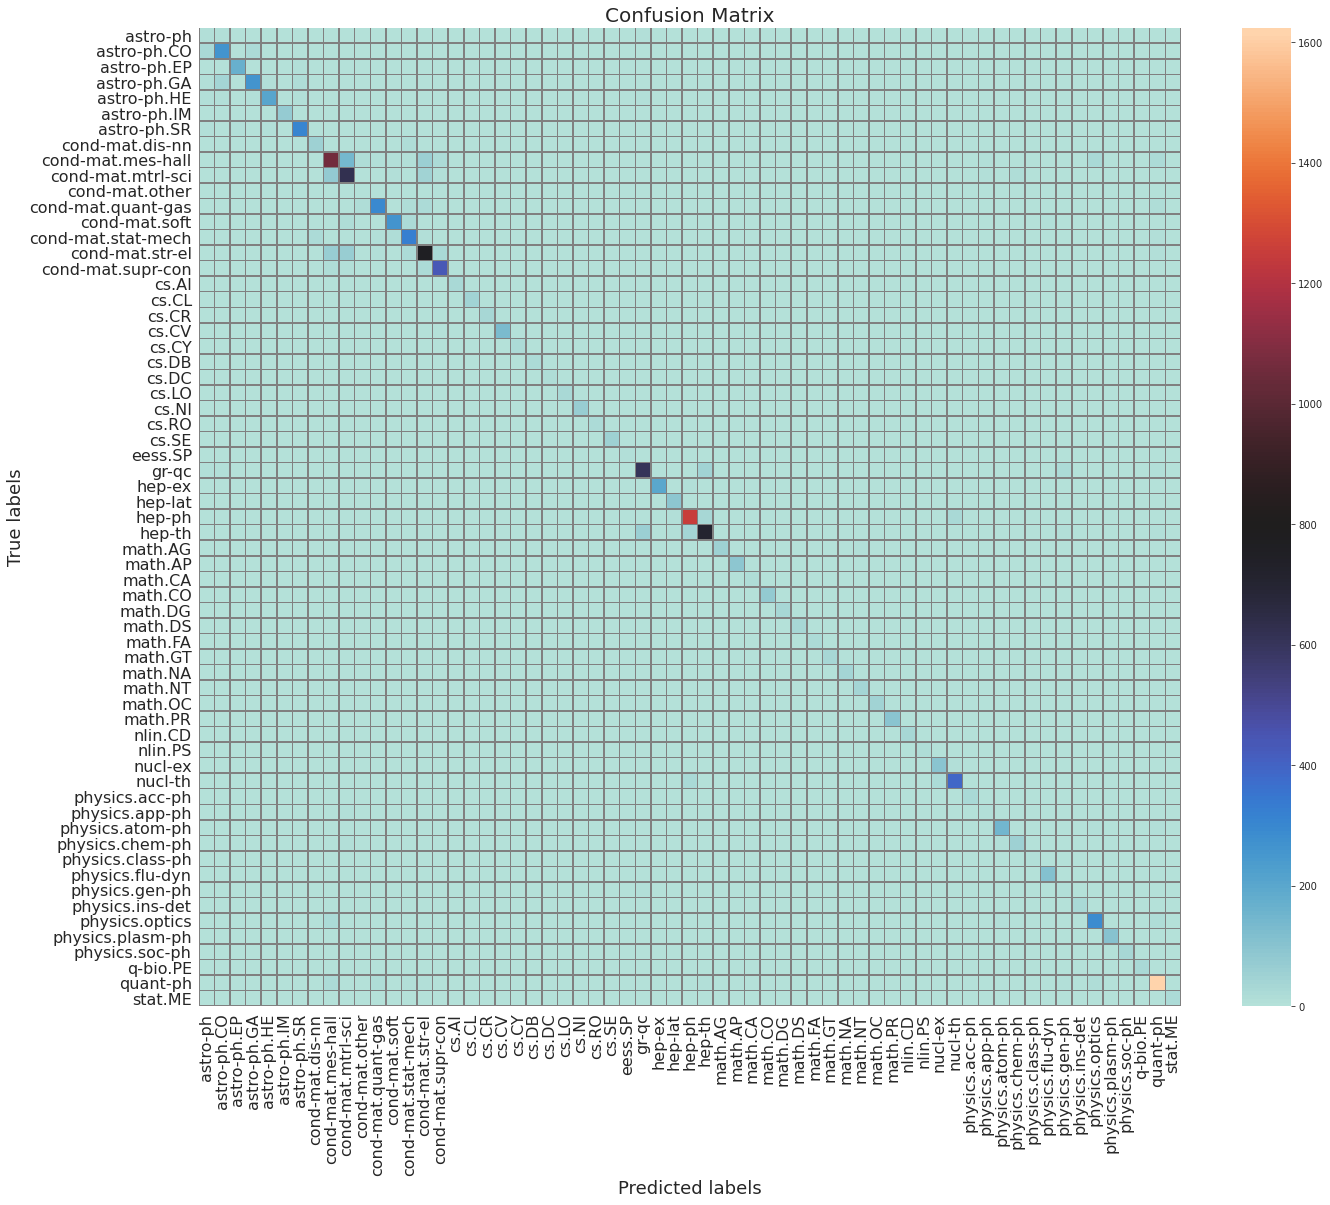

In [26]:
sns.set_style('darkgrid')

plt.figure(figsize=(22,18))
cf_matrix = confusion_matrix(predicted_categories, eval_labels, list(class_array))
ax = sns.heatmap(cf_matrix, linecolor='gray', linewidths=.5, center=800)
ax.set_xlabel('Predicted labels', fontsize=18)
ax.set_ylabel('True labels', fontsize=18)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_array, rotation=90, fontsize=16)
ax.set_yticklabels(class_array, rotation=0, fontsize=16)

plt.show()

In [28]:
import random

for _ in range(10):

    random_idx = random.randint(0, len(eval_df)-1)
    text = eval_df.iloc[random_idx]['text']
    true_categories = eval_df.iloc[random_idx]['categories']

    # Predict with trained multilabel classification model
    predicted_categories_encoded, raw_outputs = model.predict([text])
    predicted_categories_encoded = np.array(predicted_categories_encoded)
    predicted_categories_encoded[0][np.argmax(raw_outputs[0])] = 1
    predicted_categories = class_array[np.nonzero(predicted_categories_encoded[0])]

    print(f'True Categories:'.ljust(21,' '), f'{true_categories} - {cat_map[true_categories[0]]}\n')
    print(f'Predicted Categories: {predicted_categories} - {cat_map[predicted_categories[0]]}\n')
    print(f'Abstract: {text}\n\n')


True Categories:      ['cond-mat.mes-hall'] - Mesoscale and Nanoscale Physics

Predicted Categories: ['cond-mat.mes-hall'] - Mesoscale and Nanoscale Physics

Abstract: Molecular junctions and molecular motors: Including Coulomb repulsion in
  electronic friction using nonequilibrium Green's functions. We present a theory of molecular motors based on the Ehrenfest dynamics forthe nuclear coordinates and the adiabatic limit of the Kadanoff-Baym equationsfor the current-induced forces. Electron-electron interactions can besystematically included through many-body perturbation theory, making thenonequilibrium Green's functions formulation suitable for first-principlestreatments of realistic junctions. The method is benchmarked againstsimulations via real-time Kadanoff-Baym equations, finding an excellentagreement. Results on a paradigmatic model of molecular motor show thatcorrelations can change dramatically the physical scenario by, e.g. introducinga sizable damping in the self-sustaine


True Categories:      ['physics.acc-ph'] - Accelerator Physics

Predicted Categories: ['physics.acc-ph'] - Accelerator Physics

Abstract: Cascaded Multi-cycle terahertz driven ultrafast electron acceleration
  and manipulation. Terahertz (THz)-based electron acceleration and manipulation has recentlybeen shown to be feasible and to hold tremendous promise as a technology forthe development of next-generation, compact electron sources. Previous work hasconcentrated on structures powered transversely by short, single-cycle THzpulses, with mm-scale, segmented interaction regions that are ideal foracceleration of electrons in the sub- to few-MeV range where electronvelocities vary significantly. However, in order to extend this technology tothe multi-MeV range, investigation of approaches supporting longer interactionlengths is needed. Here, we demonstrate first steps in electron accelerationand manipulation using dielectrically-lined waveguides powered by temporallylong, narrowband, mult


True Categories:      ['hep-th'] - High Energy Physics - Theory

Predicted Categories: ['hep-th'] - High Energy Physics - Theory

Abstract: The Boundary Multiplet of N=4 SU(2)xU(1) Gauged Supergravity on
  Asymptotically-AdS_5. We consider N=4 SU(2)xU(1) gauged supergravity on asymptotically-AdS_5backgrounds. By a near-boundary analysis we determine the boundary-dominantcomponents of the bulk fields from their partially gauge-fixed field equations.Subdominant components are projected out in the boundary limit and we find areduced set of boundary fields, constituting the N=2 Weyl multiplet. Theresidual bulk symmetries are found to act on the boundary fields asfour-dimensional diffeomorphisms, N=2 supersymmetry and (super-)Weyltransformations. This shows that the on-shell N=4 supergravity multiplet yieldsthe N=2 Weyl multiplet on the boundary with the appropriate local N=2superconformal transformations. Building on these results we use the AdS/CFTconjecture to calculate the Weyl anomaly


True Categories:      ['cond-mat.supr-con'] - Superconductivity

Predicted Categories: ['cond-mat.supr-con'] - Superconductivity

Abstract: Correlation between non-centrosymmetry and superconductivity in
  quasi-one-dimensional compounds A2Cr3As3 (A=K, Rb). Non-centrosymmetric superconductors, whose crystal structure is absent ofinversion symmetry, have recently received special attentions due to theexpectation of unconventional pairings and exotic physics associated with suchpairings. The newly discovered superconductors A2Cr3As3 (A=K, Rb), featured bythe quasi-one dimensional structure with conducting CrAs chains, belongs tosuch kind of superconductor. In this study, we are the first to report thefinding that the superconductivity of A2Cr3As3 (A=K, Rb) has a positivecorrelation with the extent of non-centrosymmetry. Our in-situ high pressure acsusceptibility and synchrotron x-ray diffraction measurements reveal that thelarger bond angle of As-Cr-As in the CrAs chains can be taken as


True Categories:      ['astro-ph.GA'] - Astrophysics of Galaxies

Predicted Categories: ['astro-ph.GA'] - Astrophysics of Galaxies

Abstract: An imaging and spectroscopic study of the planetary nebulae in NGC 5128
  (Centaurus A): Planetary nebulae catalogues. Imaging and spectroscopic observations of planetary nebulae (PNe) in thenearest large elliptical galaxy NGC 5128 (Centaurus A), were obtained to findmore PNe and measure their radial velocities. NTT imaging was obtained in 15fields in NGC 5128 over an area of about 1 square degree with EMMI using [OIII] and off-band filters. Newly detected sources, combined with literaturePNe, were used as input for VLT FLAMES multi-fibre spectroscopy in MEDUSA mode.Spectra of the 4600-5100A region were analysed and velocities measured based onemission lines of [O III]4959,5007A and often H-beta. The chief results arecatalogues of 1118 PN candidates and 1267 spectroscopically confirmed PNe inNGC 5128. The catalogue of PN candidates contains 1060


True Categories:      ['cond-mat.quant-gas'] - Quantum Gases

Predicted Categories: ['cond-mat.stat-mech'] - Statistical Mechanics

Abstract: Temperature-driven crossover in the Lieb-Liniger model. The large-distance behavior of the density-density correlation function inthe Lieb-Liniger model at finite temperature is investigated by means of therecently derived nonlinear integral equations characterizing the correlationlengths. We present extensive numerical results covering all the physicalregimes fromweak to strong interaction and all temperatures. We find that theleading term of the asymptotic expansion becomes oscillatory at a criticaltemperature which decreases with the strength of the interaction. As weapproach the Tonks-Girardeau limit the asymptotic behavior becomes more complexwith a double crossover of the largest and next-largest correlation lengths.The crossovers exist only for intermediate couplings and vanish for $\gamma=0$and $\gamma=\infty$.





True Categories:      ['math.AP'] - Analysis of PDEs

Predicted Categories: ['math.AP'] - Analysis of PDEs

Abstract: Existence and Stability of Traveling Waves for a Class of Nonlocal
  Nonlinear Equations. In this article we are concerned with the existence and orbital stability oftraveling wave solutions of a general class of nonlocal wave equations: $u_{tt}-Lu_{xx}=B(\pm |u|^{p-1}u)_{xx}$, $ p>1$. The main characteristic of thisclass of equations is the existence of two sources of dispersion, characterizedby two coercive pseudo-differential operators $L$ and $B$. Members of the classarise as mathematical models for the propagation of dispersive waves in a widevariety of situations. For instance, all Boussinesq-type equations and theso-called double-dispersion equation are members of the class. We firstestablish the existence of traveling wave solutions to the nonlocal waveequations considered. We then obtain results on the orbital stability orinstability of traveling waves. For th


True Categories:      ['cond-mat.stat-mech'] - Statistical Mechanics

Predicted Categories: ['cond-mat.dis-nn'] - Disordered Systems and Neural Networks

Abstract: Machine-Learning Studies on Spin Models. With the recent developments in machine learning, Carrasquilla and Melko haveproposed a paradigm that is complementary to the conventional approach for thestudy of spin models. As an alternative to investigating the thermal average ofmacroscopic physical quantities, they have used the spin configurations for theclassification of the disordered and ordered phases of a phase transitionthrough machine learning. We extend and generalize this method. We focus on theconfiguration of the long-range correlation function instead of the spinconfiguration itself, which enables us to provide the same treatment tomulti-component systems and the systems with a vector order parameter. Weanalyze the Berezinskii-Kosterlitz-Thouless (BKT) transition with the sametechnique to classify three phases: the


True Categories:      ['hep-th'] - High Energy Physics - Theory

Predicted Categories: ['hep-th'] - High Energy Physics - Theory

Abstract: Q-balls without a potential. We study non-topological Q-ball solutions of the (3+1)-dimensionalFriedberg-Lee-Sirlin two-component model. The limiting case of vanishingpotential term yields an example of hairy Q-balls, which possess a long rangemassless real field. We discuss the properties of these stationary fieldconfigurations and determine their domain of existence. ConsideringFriedberg-Lee-Sirlin model we present numerical evidence for the existence ofspinning axially symmetric Q-balls with different parity. Solution of this typeexist also in the limiting case of vanishing scalar potential. We find that thehairy Q-balls are classically stable for all range of values of angularfrequency.





True Categories:      ['cond-mat.mes-hall'] - Mesoscale and Nanoscale Physics

Predicted Categories: ['cond-mat.stat-mech'] - Statistical Mechanics

Abstract: Exclusion Statistics of Quasiparticles in Condensed States of Composite
  Fermion Excitations. The exclusion statistics of quasiparticles is found at any level of thehierarchy of condensed states of composite fermion excitations (for whichexperimental indications have recently been found). The hierarchy of condensedstates of excitations in boson Jain states is introduced and the statistics ofquasiparticles is found. The quantum Hall states of charged $\alpha$-anyons($\alpha$ -- the exclusion statistics parameter) can be described asincompressible states of $(\alpha+2p)$-anyons ($2p$ -- an even number).




In [29]:
# Saving the files for use in applicaiton
output_model_file = './models/pytorch_distilbert_arxiv.bin'
output_vocab_file = './models/vocab_distilbert_arxiv.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)